<a href="https://colab.research.google.com/github/RomainCendre/DSTest/blob/main/deepsense_generative_takehome_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data modeling

Given the following [data-set](https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json).



In [1]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json")
data_1 = np.array(res.json())
print(data_1.shape)

(1542, 7)


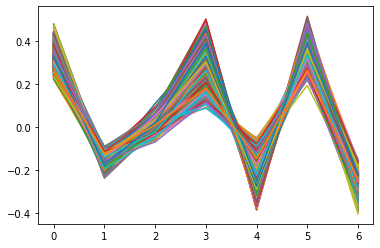

In [2]:
plt.plot(data_1.T);

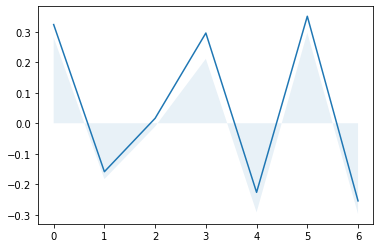

In [3]:
def mean_and_deviation(y):
    figure, axe = plt.subplots()
    x = range(y.shape[1])
    axe.plot(x, y.mean(axis=0))
    axe.fill_between(x, y.mean(axis=0) - y.std(axis=0), alpha=0.1)
    return figure
  
mean_and_deviation(data_1);

In [4]:
# plt.hist(data_1.T, bins=10);

### 1. Can you generate 10k rows of new data from the same distribution?
Following considered data as (n_samples, n_features) shape like most library does.

Depend on the purpose but this has been a long topic to counter imbalanced data annotation during the training phase. Nowadays, such ideas are not used only to counter imbalanced data issues, but also in classification topics when the number of data is insufficient.

I will distinguish two main categories :
*   Generation based on linear functions, basically consist in generating new sample by interpolation of existing data points (1990-2010)
*   Generation based on deep learning, with generative models (last decade)

In [5]:
nb_samples = 1000; # 1000 for test

#### LINEAR
##### Simple Interpolation


In [6]:
from random import random, randint

def generate_simple_interp(inputs, number):
  def interpolate(a, b, coeff):
    return a+(a-b)*coeff
  return np.array([interpolate(inputs[randint(0, len(inputs)-1)], inputs[randint(0, len(inputs)-1)], random()) for value in range(number)])

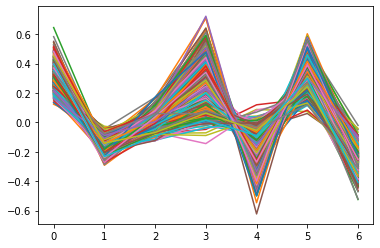

In [7]:
plt.plot(generate_simple_interp(data_1, nb_samples).T);

#### DEEP LEARNING


##### SIMPLE AE
From the following repository : https://github.com/lbun/VAE_Variational_Autoencoders/blob/master/VAE_Variational_Autoencoders_Part1.ipynb

In [8]:
from keras import callbacks, optimizers, models,layers

def get_simple_ae(inputs):
    embedding_dim = 1 

    #Input layer
    ae_input = layers.Input(shape=(inputs.shape[1],))  
    encoded = layers.Dense(embedding_dim, activation='relu')(ae_input)
    decoded = layers.Dense(inputs.shape[1],activation='sigmoid')(encoded) 

    #Autoencoder --> in this API Model, we define the Input tensor and the output layer
    #wraps the 2 layers of Encoder e Decoder
    autoencoder = models.Model(ae_input,decoded)

    #Encoder
    encoder = models.Model(ae_input,encoded)

    #Decoder
    encoded_input = layers.Input(shape=(embedding_dim,))
    decoder_layers = autoencoder.layers[-1]  #applying the last layer
    decoder = models.Model(encoded_input, decoder_layers(encoded_input))

    autoencoder.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return autoencoder, decoder


In [9]:
def generate_simple_ae(inputs, number):
  model, decoder = get_simple_ae(inputs)
  history = model.fit(inputs, inputs, epochs=100, batch_size=256, 
                      shuffle=True, validation_split=0.1, 
                      callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
  return decoder.predict(np.random.rand(number, 1))

Epoch 1/100
6/6 [==============================] - 1s 93ms/step - loss: 0.6973 - val_loss: 0.6939
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6897
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6889 - val_loss: 0.6861
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6853 - val_loss: 0.6830
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6822 - val_loss: 0.6801
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6794 - val_loss: 0.6774
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6766 - val_loss: 0.6747
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6740 - val_loss: 0.6721
Epoch 9/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6713 - val_loss: 0.6694
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6688 - val_loss: 0.6668
Epoch 11/100
6/6 [=

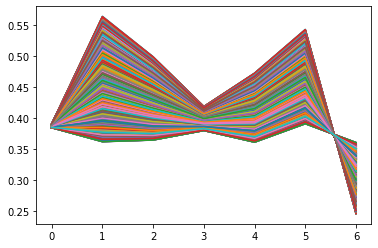

In [10]:
plt.plot(generate_simple_ae(data_1, nb_samples).T);

##### SIMPLE VAE
For this, I will based the implementation on Keras, as compared to GAN, VAE are sequential approach.
From the repository of françois chollet from keras : https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

In [109]:
import tensorflow as tf
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Flatten

class Sampling(layers.Layer):
    def call(self, inputs):
      z_mean, z_log = inputs
      epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
      return z_mean + tf.exp(0.5 * z_log) * epsilon

def get_simple_vae(inputs):  
    latent_dim = 1 

    #Input layer
    vae_input = layers.Input(shape=(inputs.shape[1],))  
    z_mean = layers.Dense(latent_dim)(vae_input)
    z_log = layers.Dense(latent_dim)(vae_input)
    z = Sampling(latent_dim)([z_mean, z_log])
    decoded = layers.Dense(inputs.shape[1], activation='sigmoid')(z) 

    vautoencoder = models.Model(vae_input,decoded)

    #Encoder
    encoder = models.Model(vae_input, z)

    #Decoder
    encoded_input = layers.Input(shape=(latent_dim,))
    decoder_layers = vautoencoder.layers[-1]  #applying the last layer
    decoder = models.Model(encoded_input,decoder_layers(encoded_input))

    vautoencoder.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return vautoencoder, decoder

In [110]:
def generate_simple_vae(inputs, number):
  model, decoder = get_simple_vae(inputs)
  history = model.fit(inputs, inputs, epochs=100, batch_size=256, 
                      shuffle=True, validation_split=0.1, 
                      callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
  return decoder.predict(np.random.rand(number, 1))

Epoch 1/100
6/6 [==============================] - 1s 43ms/step - loss: 0.7214 - val_loss: 0.7124
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7172 - val_loss: 0.7088
Epoch 3/100
6/6 [==============================] - 0s 14ms/step - loss: 0.7112 - val_loss: 0.7086
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7068 - val_loss: 0.7045
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7034 - val_loss: 0.7028
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6989 - val_loss: 0.6957
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6989 - val_loss: 0.6974
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6935 - val_loss: 0.6906
Epoch 9/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6876 - val_loss: 0.6818
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6867 - val_loss: 0.6837
Epoch 11/100
6/6 [=

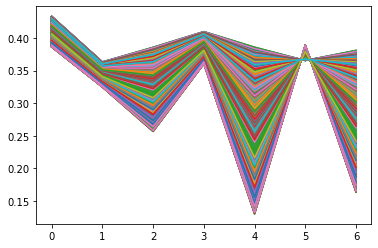

In [113]:
plt.plot(generate_simple_vae(data_1, nb_samples).T);

## GAN

In [1]:
git+https://github.com/eriklindernoren/Keras-GAN

SyntaxError: ignored


### 2. How could prior-knowledge help you in this task?

In [112]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/IdrissMg/695f423af0f0aaffd8d69bc403932c6b/raw/6f3192bbcc328f2aa53ae2faef0cefb825564ea9/data_science_test.json")
data = np.array(res.json())

In [ ]:
# The data-set is properly loaded
print(data[:10,:])